# **LAB4 AI**
Omar ahmed elsammak <br>

In [ ]:
!pip install transformers
!pip install pandas
!pip install matplotlib
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 106.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import string, re # string and regex manipulation
from nltk.corpus import stopwords
nltk.download('stopwords')
from transformers import BertTokenizer, BertModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# **Reading Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv/IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


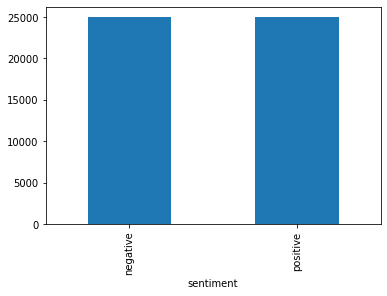

In [ ]:
df.groupby(['sentiment']).size().plot.bar()

In [ ]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
htmlRGX = re.compile('<.*?>')
lemmatizer = WordNetLemmatizer()
stop_words = stopwords.words('english')
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'negative':0,
          'positive':1
          }

In [ ]:
def data_preprocessing(text):
  sentence = re.sub(htmlRGX, ' ', text)
  sentence = "".join([char for char in sentence if char not in string.punctuation])
  sentence = sentence.lower()
  sentence = sentence.split(' ')
  sentence = [word for word in sentence if word not in stop_words]
  sentence = [lemmatizer.lemmatize(word=word,pos='v') for word in sentence]
  sentence = ' '.join(sentence)
  return sentence

changing sentiment to 1 and 0 instaed of positive and negative

In [ ]:
df['sentiment'] = [1 if each == 'positive' else 0 for each in df['sentiment']]
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


take two copies for data to use
one for data to apply preprocessing and another for unproccesed data

In [ ]:
preprocess_data= df.copy()
unprocessed_data= df.copy()

Applying preprocessing on data frame

In [ ]:
preprocess_data['review'] = preprocess_data['review'].apply(data_preprocessing)

In [ ]:
preprocess_data.head()

,review,sentiment
0,one reviewers mention watch 1 oz episode youll...,1
1,wonderful little production film technique u...,1
2,think wonderful way spend time hot summer week...,1
3,basically theres family little boy jake think ...,0
4,petter matteis love time money visually stun f...,1


In [ ]:
from sklearn.model_selection import train_test_split

# **Splitting data**

In [ ]:
def split(dataFrame):
    x, y = dataFrame.iloc[:, :-1], dataFrame.iloc[:, [-1]]  # split feature and label
    X_train, X_rem, y_train, y_rem = train_test_split(x, y, train_size=0.7, test_size=0.3, stratify=y)
    X_validate, X_test, y_validate, y_test = train_test_split(X_rem, y_rem, train_size=1/3, test_size=2/3,stratify=y_rem)
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [ ]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, x,y):

        # Map categoory to id representation
        self.labels =  torch.FloatTensor(y['sentiment'].values)
        # Tokenize text into BERT input format
        self.texts = [tokenizer(review, 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for review in x['review']]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

 

splitting preprocessed data

In [ ]:
Xpre_train, Xpre_validate, Xpre_test, ypre_train, ypre_validate, ypre_test = split(preprocess_data)
train_preprocessed, validate_preprocessed = Dataset(Xpre_train,ypre_train), Dataset(Xpre_validate,ypre_validate)
train_dataloader = torch.utils.data.DataLoader(train_preprocessed, batch_size=16, shuffle=True)
validate_dataloader = torch.utils.data.DataLoader(validate_preprocessed, batch_size=16)

splitting un-processed data

In [ ]:
Xnp_train, Xnp_validate, Xnp_test, ynp_train, ynp_validate, ynp_test = split(unprocessed_data)
train_notprocessed, validate_notprocessed = Dataset(Xnp_train,ynp_train), Dataset(Xnp_validate,ynp_validate)
train_npdataloader = torch.utils.data.DataLoader(train_notprocessed, batch_size=16, shuffle=True)
validate_npdataloader = torch.utils.data.DataLoader(validate_notprocessed, batch_size=16)

In [ ]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.relu= nn.ReLU()
        self.linear_1= nn.Linear(768,512)
        self.linear_2= nn.Linear(512,256)
        self.linear_3= nn.Linear(256,128)
        self.linear_4= nn.Linear(128,64)
        self.linear_5= nn.Linear(64,1)
        self.sigmoid=nn.Sigmoid()
    def forward(self, input_id, mask):
        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        output_layer=self.linear_1(pooled_output)
        output_layer=self.relu(output_layer)
        output_layer=self.linear_2(output_layer)
        output_layer=self.relu(output_layer)
        output_layer=self.linear_3(output_layer)
        output_layer=self.relu(output_layer)
        dropout_output = self.dropout(output_layer)
        output_layer=self.linear_4(dropout_output)
        output_layer=self.relu(output_layer)
        output_layer=self.linear_5(output_layer)
        final_layer=self.sigmoid(output_layer)

        return final_layer

In [ ]:
import pickle 
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [ ]:
def train(model, train_dataloader, val_dataloader, learning_rate, epochs,start):
    global train_accuracy,val_accuarcy,train_loss,val_loss
    use_cuda = torch.cuda.is_available() 
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.BCELoss() 
    optimizer = Adam(model.parameters(), lr= learning_rate) 
    if use_cuda:
           
            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):
            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader): 

                train_label = train_label.to(device) 
                mask = train_input['attention_mask'].to(device) # prevent looking at padding
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
          
                batch_loss = criterion(output, train_label.unsqueeze(1))
                print(f'batch_loss:{batch_loss}')
                total_loss_train += batch_loss.item()
                output      = (output >0.5).float()
                train_label = train_label.unsqueeze(1)
                
                acc = (output == train_label).sum().item() # comparing output with the real classification
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward() 
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad(): 

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)
                  
                    batch_loss = criterion(output, val_label.unsqueeze(1))
                    total_loss_val += batch_loss.item()

                    output      = (output >0.5).float()
                    val_label = val_label.unsqueeze(1)
                    
                    acc = (output == val_label).sum().item()
                    total_acc_val += acc
            
            torch.save(model.state_dict(), f'/content/drive/MyDrive/BERT/training_Models/processed_{learning_rate}/epoch_{epoch_num+1+start}/UPmodel.pt')
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {16*(total_loss_train / len(train_dataloader.dataset)): .3f} \
                | Train Accuracy: {total_acc_train / len(train_dataloader.dataset): .3f} \
                | Val Loss: {16*(total_loss_val / len(val_dataloader.dataset)): .3f} \
                | Val Accuracy: {total_acc_val / len(val_dataloader.dataset): .3f}')
            
            train_accuracy.append( total_acc_train/len(train_dataloader.dataset))
            val_accuarcy.append( total_acc_val/len(val_dataloader.dataset) )
            train_loss.append( 16*(total_loss_train/len(train_dataloader.dataset)))
            val_loss.append( 16*(total_loss_val/len(val_dataloader.dataset)))
            np.save(f'/content/drive/MyDrive/BERT/training_Models/processed_{learning_rate}/epoch_{epoch_num+1+start}/trainLoss.npy', train_loss)
            np.save(f'/content/drive/MyDrive/BERT/training_Models/processed_{learning_rate}/epoch_{epoch_num+1+start}/trainAcc.npy', train_accuracy)
            np.save(f'/content/drive/MyDrive/BERT/training_Models/processed_{learning_rate}/epoch_{epoch_num+1+start}/valLoss.npy', val_loss)
            np.save(f'/content/drive/MyDrive/BERT/training_Models/processed_{learning_rate}/epoch_{epoch_num+1+start}/valAcc.npy', val_accuarcy)


# Training The  Data

In [ ]:
LearningRates = [ 1e-3,1e-4,5e-4,1e-5,5e-5,1e-6,5e-6]

In [ ]:
import os

In [ ]:
for LR in LearningRates : 
    for _ in range(0,100):
        gc.collect() # delete unwanted objects
        torch.cuda.empty_cache() # release unoccupied cached memory
    try:
      os.makedirs(f'/content/drive/MyDrive/BERT/training_Models/processed_{LR}')
    except:
      pass

In [ ]:
    LR = 1e-3
    EPOCHS=1
    start=0
    train_accuracy = []
    val_accuarcy = []

    train_loss = []
    val_loss = []

    train_accuracy_compare = []
    val_accuarcy_compare = []

    train_loss_compare = []
    val_loss_compare = []
    UPmodel = BertClassifier()
    #UPmodel.load_state_dict(torch.load(f'/content/drive/MyDrive/BERT/training_Models/processed_{LR}/epoch_1/model.pt'))
    #for model loading
    train(UPmodel,train_dataloader, validate_dataloader, LR, EPOCHS,start)
    
    
    train_loss_compare.append(train_loss[-1])
    val_loss_compare.append(val_loss[-1])
    train_accuracy_compare.append(train_accuracy[-1])
    val_accuarcy_compare.append(val_accuarcy[-1])


    with open(f'/content/drive/MyDrive/BERT/training_Models/processed_{LR}/train_accuarcy_{LR}','wb+') as f:pickle.dump( np.array(train_accuracy), f)

    with open(f'/content/drive/MyDrive/BERT/training_Models/processed_{LR}/val_accuarcy_{LR}','wb+') as f:pickle.dump( np.array(val_accuarcy), f)

    with open(f'/content/drive/MyDrive/BERT/training_Models/processed_{LR}/train_loss_{LR}','wb+') as f:pickle.dump( np.array(train_loss), f)

    with open(f'/content/drive/MyDrive/BERT/training_Models/processed_{LR}/val_loss_{LR}','wb+') as f:pickle.dump( np.array(val_loss), f)

    epochs  =  [i for i in range(0,len(val_loss))]
    fig , (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(f'UPModel plot')
    ax1.set_ylim([0, 1])
    ax1.plot(epochs, val_loss,'g',epochs,train_loss,'b')
    ax2.set_ylim([0, 1])
    ax2.plot(epochs,val_accuarcy,'g',epochs,train_accuracy,'b')
    plt.savefig(f'/content/drive/MyDrive/BERT/training_Models/processed_{LR}/UPmodel_graph_.png') 



# Evaluation The Model

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
def evaluate(model, test_data):
    test = Dataset(test_data[0],test_data[1])
    test_dataloader = torch.utils.data.DataLoader(test, batch_size=128)
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    y_pred=[]

    if use_cuda:
        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():
        for test_input, test_label in test_dataloader:
            test_label = test_label.to(device)
            mask        = test_input['attention_mask'].to(device)
            input_id    = test_input['input_ids'].squeeze(1).to(device)
            
            output      = model(input_id, mask)

            output      = (output >0.5).float()
            y_pred.append(output.tolist())
          
            test_label  = test_label.unsqueeze(1)
            acc         = (output == test_label).sum().item()
            total_acc_test += acc
  
    y_pred = list(np.concatenate(y_pred). flat)
    report(test_data[1],y_pred)  

    print(f'Test Accuracy: {total_acc_test / len(test_data[0]): .3f}')

In [ ]:
def report(y_test, y_pred):
    TP, FP = confusion_matrix(y_test, y_pred)[0]
    FN, TN = confusion_matrix(y_test, y_pred)[1]
    print("Confusion Matrix:\n")
    print(f'TP:{TP}\tFP:{FP}\nFN:{FN}\tTN:{TN}\n')
    print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100}\n")
    print('Report:')
    print(f"{classification_report(y_test, y_pred)}\n", )


In [ ]:
best_processed = BertClassifier()
best_processed.load_state_dict(torch.load(f'/content/drive/MyDrive/BERT/training_Models/processed_1e-05/epoch_6/UPmodel.pt'))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

Processed data


In [ ]:
evaluate(best_processed, [Xpre_test, ypre_test])

Confusion Matrix:

TP:4851	FP:149
FN:286	TN:4714

Accuracy: 95.65

Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      5000
           1       0.97      0.94      0.96      5000

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000


Test Accuracy:  0.957


un-processed data

In [ ]:
best_Unprocessed = BertClassifier()
best_Unprocessed.load_state_dict(torch.load(f'/content/drive/MyDrive/BERT/training_Models/Unprocessed_5e-06/epoch_6/UPmodel.pt'))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [ ]:
evaluate(best_Unprocessed, [Xnp_test, ynp_test])

Confusion Matrix:

TP:4952	FP:48
FN:293	TN:4707

Accuracy: 96.59

Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5000
           1       0.99      0.94      0.97      5000

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000


Test Accuracy:  0.966
